In [26]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from keras.preprocessing import image

Using TensorFlow backend.


In [68]:
path_to_data = 'D:\Voice\df_all.csv'

In [69]:
df_all = pd.read_csv(path_to_data) # read concatenated dataframe df_all

In [70]:
df_all

,path,age,gender,language
0,common_voice_ru_19793729.png,twenties,1,ru
1,common_voice_ru_19793731.png,twenties,1,ru
2,common_voice_ru_19793733.png,twenties,1,ru
3,common_voice_ru_19793737.png,twenties,1,ru
4,common_voice_ru_19793749.png,twenties,1,ru
...,...,...,...,...
5991,common_voice_de_19118397.png,twenties,0,de
5992,common_voice_de_19118398.png,twenties,0,de
5993,common_voice_de_19118400.png,twenties,0,de
5994,common_voice_de_19118401.png,twenties,0,de


In [51]:
df_all['age'].unique()

array(['twenties', 'thirties', 'teens', 'fourties', 'sixties', 'fifties',
       'eighties', 'seventies'], dtype=object)

In [52]:
df_all['language'].unique()

array(['ru', 'cn', 'en', 'de'], dtype=object)

In [53]:
df_all['gender'].unique()

array([1, 0], dtype=int64)

In [54]:
male_sum = df_all['gender'].sum()
female_sum = df_all.shape[0]-male_sum
print('Male :', male_sum, 'Female :', female_sum)

Male : 5422 Female : 574


In [ ]:
#look at the distribution of classes

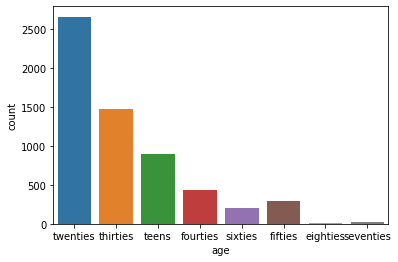

In [55]:
sns.countplot(df_all['age'])


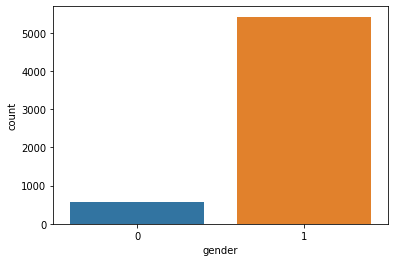

In [56]:
sns.countplot(df_all['gender'])

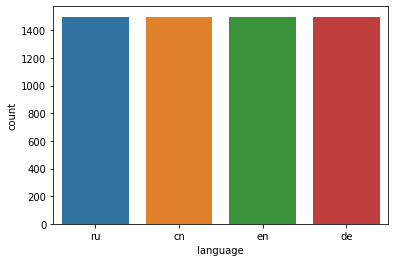

In [57]:
sns.countplot(df_all['language'])

In [ ]:
df_all.loc[(df_all['language'] == 'ru')] = 0 
df_all.loc[(df_all['language'] == 'en')] = 1
df_all.loc[(df_all['language'] == 'cn')] = 2
df_all.loc[(df_all['language'] == 'de')] = 3

In [ ]:
print ('Ru :0','En:1','Cn:2','De:3')

In [ ]:
df_all

# quick model test

In [ ]:
img_shape

In [29]:
# loading images into a numpy matrix for training before train_test_split
X=[] 
for i in tqdm(range(df_all.shape[0])):
  path_spect = 'D:/Voice/spect/' + df_all['path'][i]
  img = image.load_img(path_spect,target_size=(129,500,1))
  img = image.img_to_array(img)
  img = img/255.0
  X.append(img)
X = np.array(X)

100%|██████████| 5996/5996 [03:59<00:00, 25.00it/s]


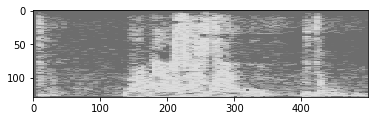

In [30]:
plt.imshow(X[1])

In [31]:
X.shape

(5996, 129, 500, 3)

In [86]:
from keras. models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,BatchNormalization
from keras.preprocessing import image
from keras.regularizers import l2
import os
import shutil
import matplotlib.pyplot as plt
from tqdm import tqdm
import keras
from sklearn.model_selection import train_test_split

In [80]:
#try to learn the language model
y = df_all.drop(['path','age','gender'], axis=1)

In [ ]:
#from sklearn.preprocessing import OneHotEncoder
#one_hot= OneHotEncoder(sparse=False)
#y_categorical = one_hot.fit_transform(y['language'].values.reshape(-1,1))
#tmp = pd.DataFrame(y_categorical,columns=['ru','cn','en','de'])
#y = pd.concat([y,tmp],axis=1)
#y

In [81]:
# break up y to categorical
y['language'] = pd.Categorical(y['language'])
y = pd.get_dummies(y['language'],prefix='lan')

In [82]:
y

,lan_cn,lan_de,lan_en,lan_ru
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
5991,0,1,0,0
5992,0,1,0,0
5993,0,1,0,0
5994,0,1,0,0


In [83]:
y = y.to_numpy()

In [84]:
y.shape

(5996, 4)

In [85]:
X_train, X_test, y_train,y_test = train_test_split(X,y,random_state=7,test_size=0.20)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced',np.unique(y_train),y_train.argmax(axis=1))
print('class weights: ', class_weights)

# MODEL TEST

In [109]:
model = Sequential()

model.add(Conv2D(16,(7,7),strides=2,activation='relu',input_shape=(129,500,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(32,(5,5),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(4,activation='softmax'))

In [110]:
model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics=['accuracy']) 

In [111]:
history = model.fit(X_train,y_train, epochs=30, batch_size=32, validation_data=(X_test,y_test))

Train on 4796 samples, validate on 1200 samples
Epoch 1/30
4796/4796 [==============================] - 144s 30ms/step - loss: 1.5281 - accuracy: 0.4504 - val_loss: 6.3872 - val_accuracy: 0.2608
Epoch 2/30
4796/4796 [==============================] - 158s 33ms/step - loss: 1.0263 - accuracy: 0.5365 - val_loss: 3.0079 - val_accuracy: 0.2825
Epoch 3/30
4796/4796 [==============================] - 128s 27ms/step - loss: 0.8829 - accuracy: 0.6009 - val_loss: 1.3567 - val_accuracy: 0.5175
Epoch 4/30
4796/4796 [==============================] - 128s 27ms/step - loss: 0.7941 - accuracy: 0.6453 - val_loss: 1.2711 - val_accuracy: 0.5250
Epoch 5/30
4796/4796 [==============================] - 134s 28ms/step - loss: 0.7097 - accuracy: 0.6925 - val_loss: 1.4805 - val_accuracy: 0.4975
Epoch 6/30
4796/4796 [==============================] - 126s 26ms/step - loss: 0.6567 - accuracy: 0.7148 - val_loss: 5.1373 - val_accuracy: 0.3092
Epoch 7/30
4796/4796 [==============================] - 121s 25ms/step

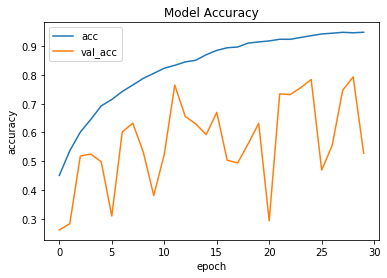

In [112]:
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc','val_acc'], loc='upper left')
plt.show()

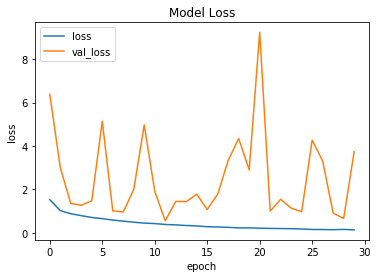

In [113]:
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','val_loss'], loc='upper left')
plt.show()